In [117]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mechanistic_model import ODE_model, prepare_ODE_model_data, fit_ODE_model
from scipy.integrate import odeint
from pygom import SimulateOde
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
# setting up the plotting
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 12 

# Epidemic simulaitons

The model used to simulated epidemics is stored in mechanisitic_model.py alongside other utility functions. Although the model is relatively simple, care has been tkaen to ensure erlang distributed exposed and infected compartments, as well as accounting for detcted and undetected cases. 

## Model

The following ODE model is used to simulate cases:

\begin{align}
 \label{S}
    \frac{dS}{dt} &= -\beta S \frac{I}{N_0- I} \\
 \label{E0}
    \frac{dE_0}{dt} &= \beta S \frac{I}{N_0- I} - \alpha_0 E_0 \\
 \label{E1}
    \frac{dE_1}{dt} &= \alpha_0 E_0 - \alpha_1 E_1 \\
\label{E2}
    \frac{dE_2}{dt} &= \alpha_1 E_1 - \alpha_2 E_2 \\
 \label{I0}
    \frac{dI_0}{dt} &= \alpha_2 E_2 - \gamma \\
 \label{Id}
    \frac{dI_d}{dt} &= k \cdot \gamma I_0 - \delta_d I_d \\
 \label{Iu}
    \frac{dI_u}{dt} &= (1-k) \cdot \gamma I_0 - \delta_u I_u \\
 \label{R}
    \frac{dR}{dt} &= \delta_d I_d + \delta_u I_u
\end{align}

Where $I_d$ and $I_u$ refer to detected and undetected cases respectively.  Note that becase we are using cumulative case numbers, the code contains an extra psuedo-compartment $I_{cum}$ which collects all individuals passing out of the $I_0$ compartment and into $I_d$. The $R$ compartment refers to both recoveries and deaths.

All dates are inputted relative to the first day in the dataset. The 'assumed_lag' parameter dictates how many post-intervention data points are included in the fitting process. This allows for the incorporation of more data points, but care should betaken to ensure it remains below the incubaiton period of the disease.

In [118]:
# Funcitons for weighting and parameterising the NegBinomLoss function

def calculate_fit_weights(data):
    weights = [1]
    
    for x in range(1, len(data)):
        if data[x] == 0:
            weight = 0.0001
        else:
            weight = (data[x] - data[x-1])/data[x]
        
        if weight == 0:
            weight = 0.00001 # Note weights can not be zero
        weights.append(weight)
    return weights

# Estimating alpha for NegBinomLoss 
# adapted from https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4
def fit_poisson(endog, exog, weights):
    poiss = sm.GLM(endog, exog, family=sm.families.Poisson(), weights=weights).fit()
    lambdas = poiss.mu
    df_train = pd.DataFrame(columns=['BB_count', 'BB_lambda', 'Aux_OLS_dep'])
    df_train['BB_count']=endog
    df_train['BB_lambda']=lambdas
    return df_train


def fit_auxiliary_OLS(df_train):
    df_train['Aux_OLS_dep'] = df_train.apply(lambda x:\
                                             ((x['BB_count']\
                                               - x['BB_lambda'])**2 \
                                               - x['BB_count'])\
                                               / x['BB_lambda'], axis=1)   
    ols_expr = """Aux_OLS_dep ~ BB_lambda - 1"""
    aux_olsr_results = smf.ols(ols_expr, df_train).fit()
    return aux_olsr_results.params.BB_lambda


def estimate_over_dispersion(data, weights):
    endog = data
    exog = np.linspace(0, len(data)-1, len(data))
    df_train = fit_poisson(endog, exog, weights)
    alpha = fit_auxiliary_OLS(df_train)
    k = 1/alpha
    return k

In [119]:
nat_pop_dict = {'DK':5.8e6, 'NO':5.37e6, 'SE':1.02e7}
int_day_dict = {'SE':47, 'DK':12, 'NO':4}

In [120]:
# Specify parameters
country = 'SE' # Two letter country code
metric = 'cases' # 'cases' or 'hospitalisations'
N0 = nat_pop_dict[country]
start_date = 0 # Pretty much always zero...
int_date = int_day_dict[country]-start_date # Date of closures
end_date = 70 # Final date of simulation
assumed_lag = 5 # 5 days for cases and hospitalisations
num_sims = 150 # Number of posterior parameterisations

In [121]:
# Load in the data and extract the useful parts
nat_data = pd.read_csv('raw_data/{}_data.csv'.format(country))[start_date:]
nat_data = nat_data.filter([metric]) 
nat_data = nat_data.dropna(axis=0)
# Want to save this as a seperate dataframe
df = pd.DataFrame(columns=[metric])
df[metric] = [int(x) for x in nat_data[metric]]
df.to_csv('GP_input_data/{}_{}_data.csv'.format(country, metric))

## ABC fitting
Functions initialising and running the ABC fitting process can be found in mechanisitic_model.py. Posteriors are estimated for all parameters, with the exception of $\alpha_i$, which is set to 1.7, such that $\sum_{i=0}^2\alpha_i = 5.1$ - a reasonable approximation of the known incubation period of Covid-19. Initial Exposed populaiton is also estimated during the ABC fitting process. 

In [151]:
# Preparations for ABC fitting
fit_data, fit_end_point = prepare_ODE_model_data(df=nat_data, 
                                                 fit_to=metric, 
                                                 N_to_fit=int_date+assumed_lag)
# Estimate over dispersion (k) of fitting data and calculate weightings
weights = calculate_fit_weights(fit_data)
k = estimate_over_dispersion(fit_data, weights)
# A poisson distribution works a lot better for Sweden due to inconsistencies in early growth rate:
#if country == 'SE':
#    k = k*2000
#if k < 0:
#    k = -k

In [152]:
fit_data

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    2,    3,   11,   14,   14,   19,   32,
         62,   87,  146,  179,  225,  326,  424,  620,  771,  923,  994,
       1063, 1146, 1265, 1410, 1553, 1733, 1867, 1983])

In [153]:
# Run ABC fitting. 10 generations is usually sufficient. 
ode_model, fitted_model = fit_ODE_model(full_data=nat_data,
                                         fit_data=fit_data, 
                                         fit_to=metric, 
                                         fit_end_point=fit_end_point,
                                         weights=weights,
                                         k=k*np.ones(len(fit_data)),
                                         N0=N0,
                                         generations=10)        

Using NegBinomLoss
Generation 1 
 tolerance = inf 
 acceptance rate = 100.00%

Generation 2 
 tolerance = 6372.48970 
 acceptance rate = 2.97%

Generation 3 
 tolerance = 4070.32230 
 acceptance rate = 4.78%

Generation 4 
 tolerance = 2147.96664 
 acceptance rate = 3.41%

Generation 5 
 tolerance = 985.79416 
 acceptance rate = 3.61%

Generation 6 
 tolerance = 568.33425 
 acceptance rate = 3.29%

Generation 7 
 tolerance = 443.87739 
 acceptance rate = 3.10%

Generation 8 
 tolerance = 365.74003 
 acceptance rate = 2.82%

Generation 9 
 tolerance = 323.75598 
 acceptance rate = 2.30%

Generation 10 
 tolerance = 296.16119 
 acceptance rate = 2.15%



# Simulation 

A random selection of posteriors generated by the ABC fitting method are used to produce a simulated epidemic curve. Since the ABC fitting is done up to (or just past) intervention, it can be assumed that these can act as counter factuals to the observed cases under intervention. 


In [154]:
model = ode_model
times = np.linspace(0,end_date-1,end_date)

curve_idx_dict = {'cases':7, 'hospitalisations':7, 'tot_hosps':5, 'new_cases':5}
curve_idx = curve_idx_dict[metric]
n = 0
pred = np.zeros((num_sims,len(times)))
sim = np.zeros((num_sims,len(times)))
I0 = 0
Eb0 = 0
Ec0 = 0
Id0 = 0
Iu0 = 0
R0  = 0
Id_cum0 = 0
null_series = 0

for i in range(num_sims):
    print('Simulating posterioir {}'.format(i))
    p_beta, p_gamma, p_kappa, p_delta1, p_delta2, p_Ea0, p_Eb0, p_Ec0, p_I0, p_Id0, p_Iu0 = fitted_model.res[i]
    model.parameters = {'beta':p_beta,
                        'alpha0':1.6,
                        'alpha1':1.6,
                        'alpha2':1.6,
                        'gamma':p_gamma, 
                        'kappa':p_kappa,
                        'delta1':p_delta1,
                        'delta2':p_delta2,
                        'N0':N0}

    solution = odeint(model.ode,[N0-(p_Ea0+p_Eb0+p_Ec0+p_I0+p_Id0+p_Iu0+R0), 
                                 np.round(p_Ea0),np.round(p_Eb0),np.round(p_Ec0), np.round(p_I0), np.round(p_Id0)
                                 , np.round(p_Iu0), Id_cum0, R0],times).T[curve_idx]
    if sum(solution) != 0:
        pred[i] = solution


Simulating posterioir 0
Simulating posterioir 1
Simulating posterioir 2
Simulating posterioir 3
Simulating posterioir 4
Simulating posterioir 5
Simulating posterioir 6
Simulating posterioir 7
Simulating posterioir 8
Simulating posterioir 9
Simulating posterioir 10
Simulating posterioir 11
Simulating posterioir 12
Simulating posterioir 13
Simulating posterioir 14
Simulating posterioir 15
Simulating posterioir 16
Simulating posterioir 17
Simulating posterioir 18
Simulating posterioir 19
Simulating posterioir 20
Simulating posterioir 21
Simulating posterioir 22
Simulating posterioir 23
Simulating posterioir 24
Simulating posterioir 25
Simulating posterioir 26
Simulating posterioir 27
Simulating posterioir 28
Simulating posterioir 29
Simulating posterioir 30
Simulating posterioir 31
Simulating posterioir 32
Simulating posterioir 33
Simulating posterioir 34
Simulating posterioir 35
Simulating posterioir 36
Simulating posterioir 37
Simulating posterioir 38
Simulating posterioir 39
Simulating

In [155]:
# Store the simulated data
simulated_data = {}
for idx, data in enumerate(pred):
    simulated_data.update({idx:data})

In [156]:
# Save the results
det_df = pd.DataFrame.from_dict(simulated_data)
# Generally only interested in stochastic data, although deterministic can be useful for longer sims.
det_df.to_csv('simulated_data/simulated_{}_{}.csv'.format(metric, country))

(0, 10000)

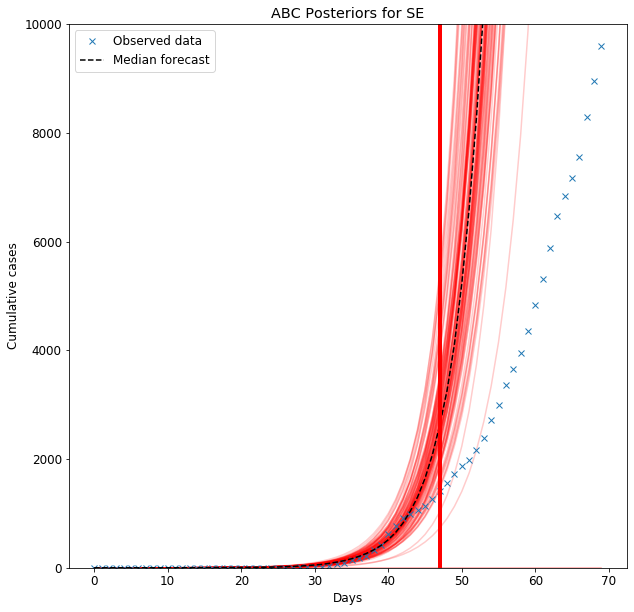

In [157]:
# Plot to check everything looks sensible.
#start_date = int_date-10
df = pd.read_csv('simulated_data/simulated_{}_{}.csv'.format(metric, country))
for x in range(100):
    plt.plot(pred[x][start_date:], 'r', alpha=0.2)
t = np.linspace(0,end_date-1,end_date)
plt.plot(t, nat_data[metric][:end_date], 'x', label = 'Observed data')
plt.plot(np.median(pred, axis=0)[start_date:end_date], 'k--', label = 'Median forecast')
plt.title('ABC Posteriors for {}'.format(country))
plt.ylabel('Cumulative cases')
plt.xlabel('Days')
plt.axvline(x=int_date, linewidth=4, color="r")
#plt.axvline(x=int_date+assumed_lag, linewidth=2, color="r")
plt.legend()
plt.ylim([0, 10000])
#plt.xlim([0,30])
#plt.yscale('log')

In [158]:
## Check that num observations and num simulated data points are the same!
assert len(pred[0])==len(nat_data[metric][start_date:end_date])


In [159]:
len(pred[0])

70

In [ ]:
len